# 数据读取
读取csv数据，初次得到的数据结构如下：
```
data=
[
    {
        'date',
        'time',
        'data':[
            第road_id行，存放road_id的数据：[status,speed]
        ]
        不同时间的不同data不等长
    }
]
```

In [1]:
import csv
import os
file_path='data'
file_list=sorted(os.listdir(file_path))
date_time={}
for fname in file_list:
    if fname[0]=='.':
        continue
        
    date=fname[8:13]
    time=fname[14:22]
    
    if date>='10-02' and date<='10-31':
        if date not in date_time:
            date_time[date]=[time]
        else:
            date_time[date].append(time)
#把每一天的时间段数据归一化，抛弃尾端数据
min_time_num=216
for date,times in date_time.items():
    if len(times)<min_time_num:
        min_time_num=len(times)
for date in date_time:
    if len(date_time[date])>min_time_num:
        date_time[date]=date_time[date][0:min_time_num]

road_dict={}
data=[]

for date,times in date_time.items():
    for time in times:
        fname='ts_2021-'+date+' '+time+'.csv'
        date_data=[[0,0] for i in range(len(road_dict))]
        with open(file_path+'/'+fname,'r') as f:
            csv_reader = csv.reader(f)
            for row in csv_reader:
                if (row[0],row[2]) in road_dict:
                    date_data[road_dict[(row[0],row[2])]['id']][0]=int(row[1])
                    date_data[road_dict[(row[0],row[2])]['id']][1]=int(row[4])
                else:
                    road_dict[(row[0],row[2])]={'id':len(road_dict)}
                    date_data.append([int(row[1]),int(row[4])])
            f.close()
        #time=(int(fname[14:16])-5)*60+int(fname[17:19])
        data.append({'date':date,'time':time,'data':date_data})

读取拓扑图数据

In [2]:
import pickle
orthogonal_list={}
pointers={}
node_dict={}
node_dict_amap={}
with open('map_nodes.pkl','rb') as f:
    node_dict=pickle.load(f)
with open('map_nodes_amap.pkl','rb') as f:
    node_dict_amap=pickle.load(f)
with open('graph_orthogonal_list.pkl','rb') as f:
    orthogonal_list=pickle.load(f)
with open('graph_pointers.pkl','rb') as f:
    pointers=pickle.load(f)

# 数据清洗
二次处理读到的csv数据，使其转化为光栅(Raster)数据
```
dataset=[
    for each day
    [
        for each roads
        [
            for each time
            [
                [status,speed]
            ]
        ]
    ]
]
```
记每天为一个样本组，天数=样本数=N，每个样本记录了E个道路信息，每个道路包含T个时间片的监测数据，每个数据有C个特征

In [3]:
import numpy as np
from collections import Counter
dataset=[]
raster=[[] for i in range(len(road_dict))]
for index,item in enumerate(data):
    for road in road_dict:
        road_id=road_dict[(road)]['id']
        if road_id<len(item['data']):
            raster[road_id].append(item['data'][road_id])
        else:
            raster[road_id].append([0,0])

    if index==len(data)-1 or item['date']!=data[index+1]['date']:
        dataset.append(raster)
        raster=[[] for i in range(len(road_dict))]

dataset=np.array(dataset)

将每一天的数据拼接
```
dataset=[
    for each roads
    [
        for all time
        [
            [status,speed]
        ]
    ]
]
```
样本记录了E个道路信息，每个道路包含N*T个时间片的监测数据，每个数据有C个特征

In [4]:
dataset=np.concatenate(dataset,axis=1)

将数据缺失率在5%以上的路段剔除<br>
road_zip是之后代码块使用的数据源

In [5]:
road_zip=dict(zip(road_dict.keys(), dataset))
delete_roads=[]
for road,data in road_zip.items():
    null_cnt=0
    zero_cnt=Counter(data[:,0])[0]
    if zero_cnt>len(data)*0.05:
        delete_roads.append(road)
for road in delete_roads:
    road_zip.pop(road)

绘制光栅图

In [6]:
#print(road_dict)
import cv2 as cv
sample=np.array(list(road_zip.values()))
print(sample.shape)
image=85*sample[:,:,0]

cv.imwrite("filename.png", image)

(1029, 6090, 2)


True

In [7]:
#从道路方向信息中解析出道路的起讫点
def decode_direction(direction):
    begin,end='',''
    if direction[0]=='从':
        strlist=direction.split('到')
        begin=strlist[0][1:]
        end=strlist[1]
    elif direction[-2:]=='附近':
        begin=direction[:-2]
        end=direction[:-2]
    return begin,end

spatial_maps={}
for road,value in road_zip.items():
    begin,end=decode_direction(road[1])
    address=[]
    if road[0] in pointers:
        for p in pointers[road[0]]:
            if p[0]==begin or p[0]==end or p[1]==begin or p[1]==end:
                address.append([p[2],p[3]])
        spatial_maps[road]={'pointer':address,'data':value}

964


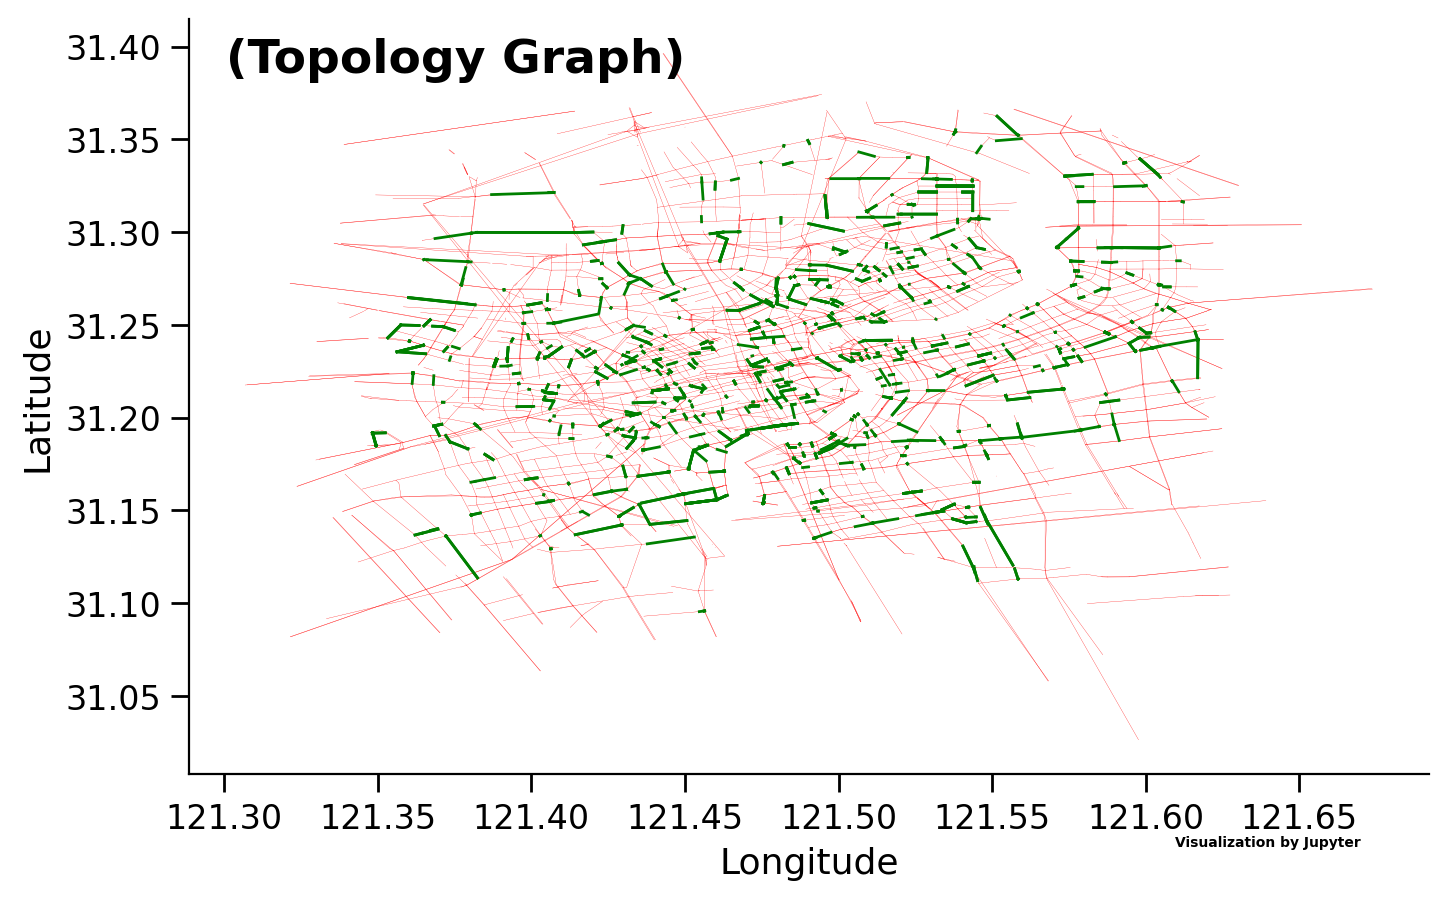

In [16]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=(8,5),dpi=200)
ref=node_dict_amap
for key,value in orthogonal_list.items():
    for e in value[1]:
        ax.plot([float(ref[key][0]),float(ref[e[1]][0])],[float(ref[key][1]),float(ref[e[1]][1])],color='r',linewidth=.1)
for road,value in spatial_maps.items():
    for p in value['pointer']:
        edge=orthogonal_list[p[0]][1][p[1]]
        ax.plot([float(ref[p[0]][0]),float(ref[edge[1]][0])],[float(ref[p[0]][1]),float(ref[edge[1]][1])],color='g',linewidth=1)

ax.tick_params(direction='out',labelsize=12,length=6.5,width=1,top=False,right=False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Latitude',fontsize=13)
ax.set_xlabel('Longitude',fontsize=13)
text_font = {'size':'17','weight':'bold','color':'black'}
ax.text(.03,.93,'(Topology Graph)',transform = ax.transAxes,fontdict=text_font,zorder=4)
ax.text(.87,-.08,'\nVisualization by Jupyter',transform = ax.transAxes, ha='center', va='center',fontsize = 5,color='black',fontweight='bold')
fig.show()